<a href="https://www.kaggle.com/code/damlapeker/diabetes-data-analysis-feature-engineering?scriptVersionId=173500760" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

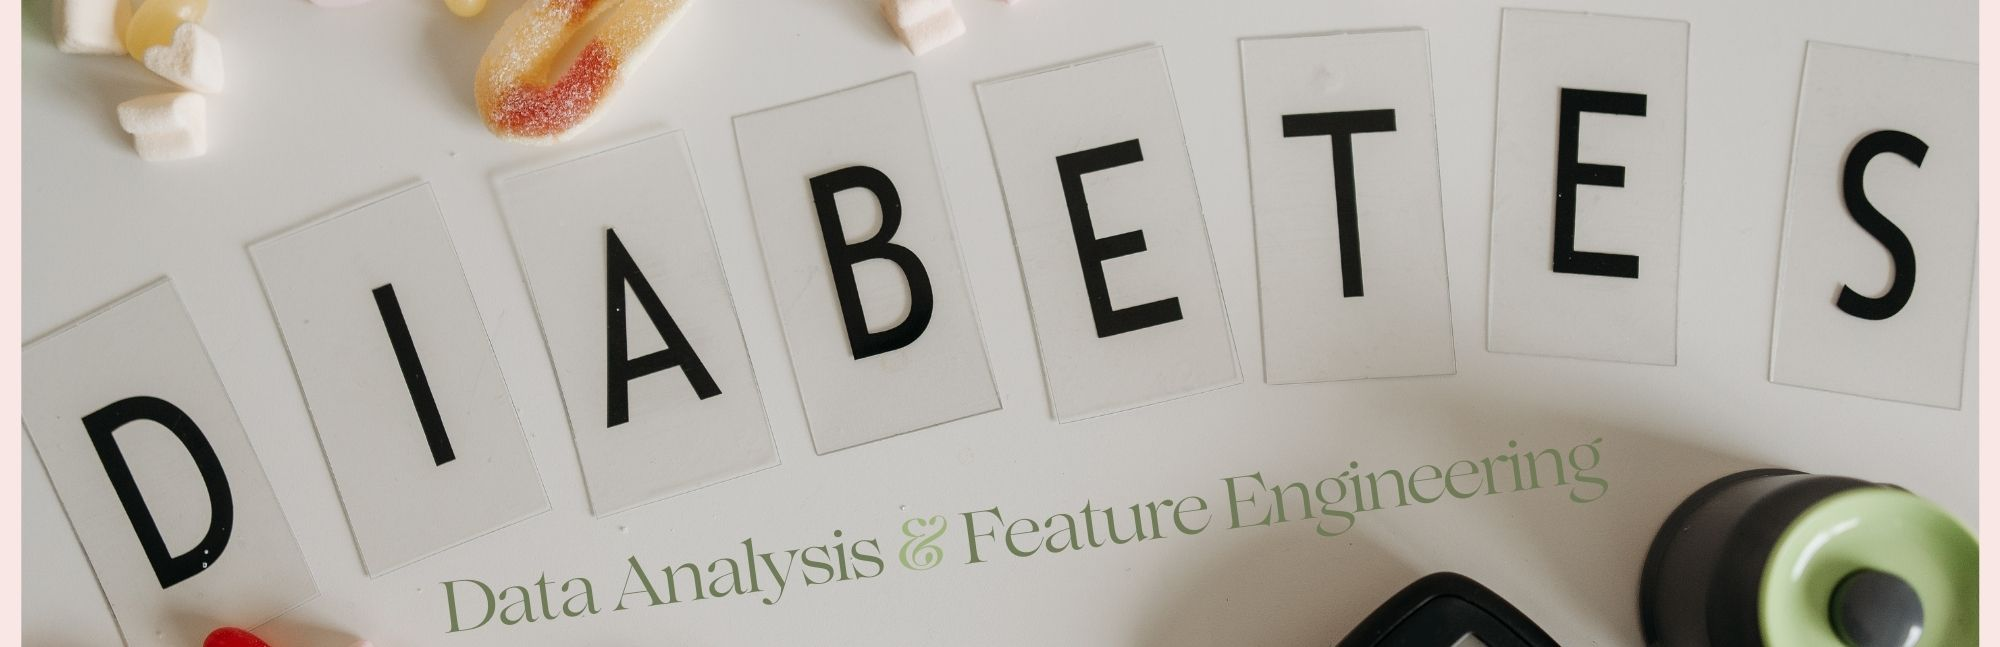

# 1-Preperation

## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
import plotly.graph_objects as go

# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

## Adjusting Row Column Settings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
#Read data
df = pd.read_csv("/kaggle/input/diabetes-dataset/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


<div style="border-radius: 10px; border: solid #484366;padding: 15px; background-color: #FFECC3; font-size:100%; text-align:left">

**Dataset variables:**
    
**Pregnancies:** Number of pregnancies

**Glucose:** 2-hour plasma glucose concentration in oral glucose tolerance test

**Blood Pressure:** Blood Pressure (small blood pressure) (mm Hg)

**SkinThickness:** Skin Thickness

**Insulin:** 2-hour serum insulin (mu U/ml)

**DiabetesPedigreeFunction:** Function (2-hour plasma glucose concentration in oral glucose tolerance test)

**BMI:** Body mass index

**Age:** Age (years)

**Outcome:** Have the disease (1) or not (0)

# 2-Overview of Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
custom_percentiles = [0.01, 0.25, 0.5, 0.75, 0.99]
description = df.describe(percentiles=custom_percentiles).T
description

,count,mean,std,min,1%,25%,50%,75%,99%,max
Pregnancies,768.000,3.845,3.370,0.000,0.000,1.000,3.000,6.000,13.000,17.000
Glucose,768.000,120.895,31.973,0.000,57.000,99.000,117.000,140.250,196.000,199.000
BloodPressure,768.000,69.105,19.356,0.000,0.000,62.000,72.000,80.000,106.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,0.000,23.000,32.000,51.330,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,0.000,30.500,127.250,519.900,846.000
BMI,768.000,31.993,7.884,0.000,0.000,27.300,32.000,36.600,50.759,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.095,0.244,0.372,0.626,1.698,2.420
Age,768.000,33.241,11.760,21.000,21.000,24.000,29.000,41.000,67.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,0.000,1.000,1.000,1.000


# 3-Analysis of Numeric and Categorical Variables

## Analysis of Categorical Variables

In [6]:
df.head() 
#If we were to look at numerical-looking categorical variables, it seems like there is an 'Outcome' column

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
  # Categorical columns: Those of type 'object
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == "O"]
    
    #  Numeric-looking but actually categorical columns: Those of numeric data type with a unique value count below cat_th
    num_but_cat = [col for col in dataframe.columns if (dataframe[col].dtype != "O") and (dataframe[col].nunique() < cat_th)]

    # Columns that appear to be categorical but could actually be converted to numerical values: Those of 'object' type with a unique value count below car_th
    cat_but_car = [col for col in dataframe.columns if (dataframe[col].dtype == "O") and (dataframe[col].nunique() > car_th)]
    
    cat_cols = cat_cols + num_but_cat
    
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # Numeric columns:
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car



In [8]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [9]:
cat_cols, num_cols, cat_but_car

(['Outcome'],
 ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age'],
 [])

In [10]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


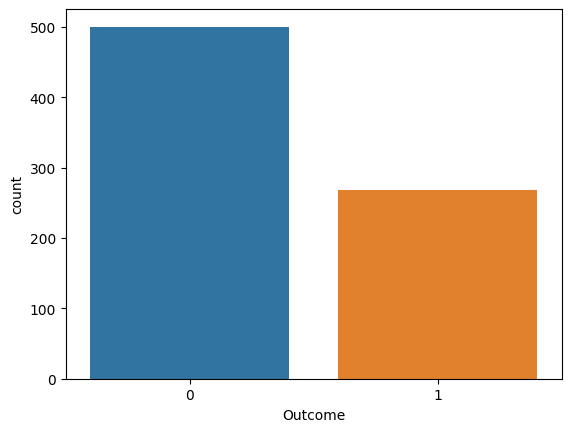

In [11]:
# We did it this way because there is only one categorical variable.

cat_summary(df, "Outcome", plot=True)

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


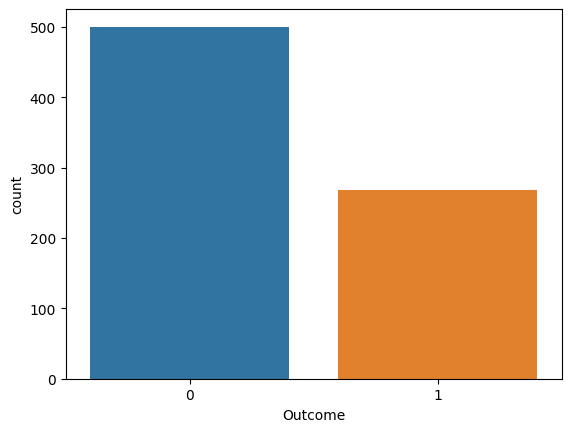

In [12]:
# If there were more than one categorical variable, we would loop through all categorical variables one by one as follows to run the function.

for col in cat_cols:
    cat_summary(df, col, plot=True)

## Analysis of Numerical Variables

In [13]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


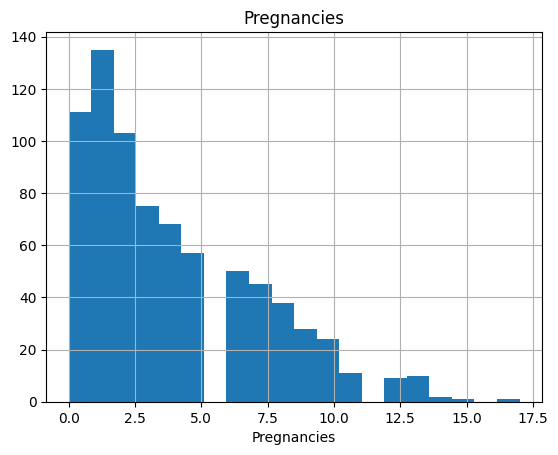

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


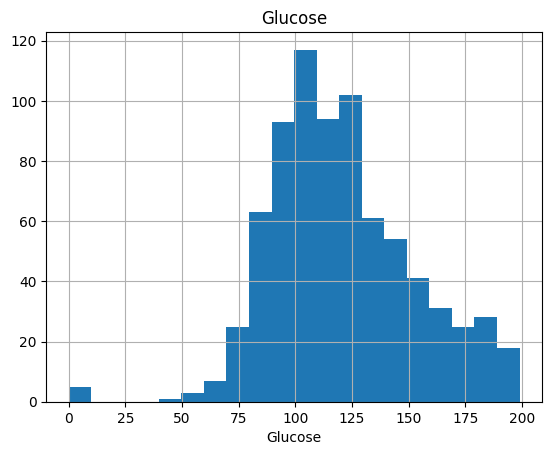

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


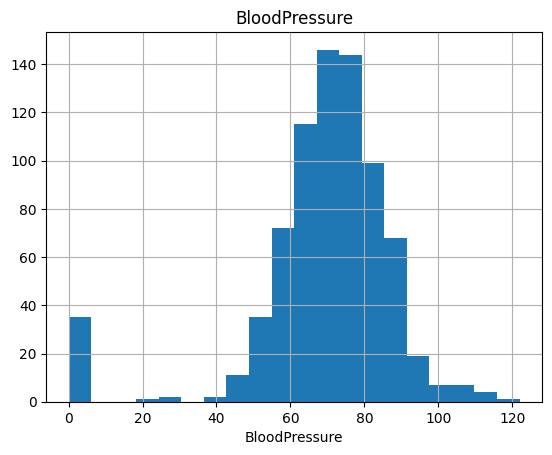

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


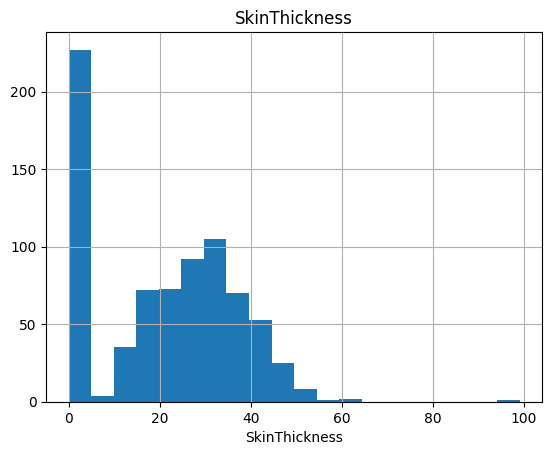

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


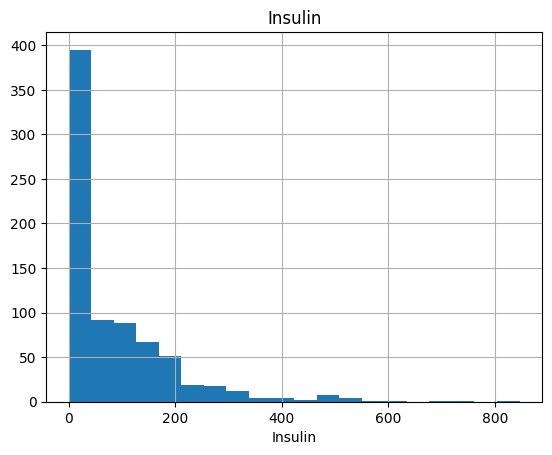

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


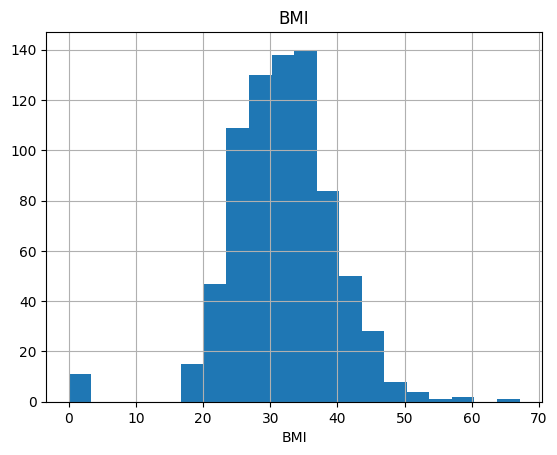

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


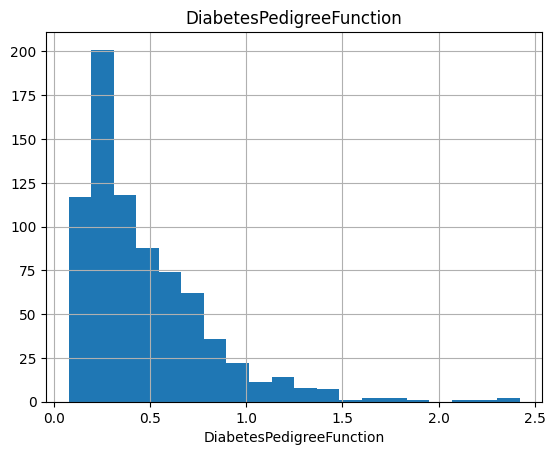

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


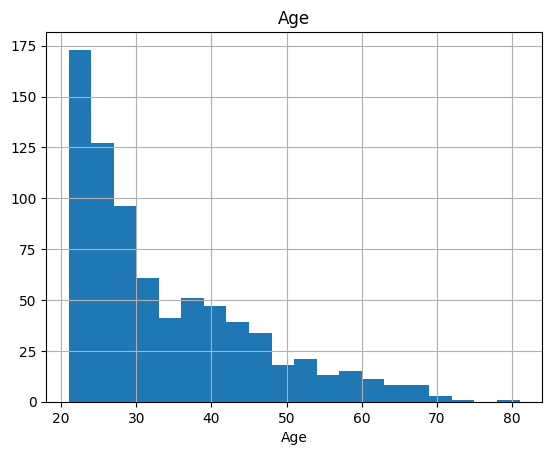

In [14]:
for col in num_cols:
    num_summary(df, col, plot=True)

## Analysis of Categorical Variables by Target

In [15]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe)
        plt.show(block=True)

         TARGET_MEAN
Outcome             
0              0.000
1              1.000




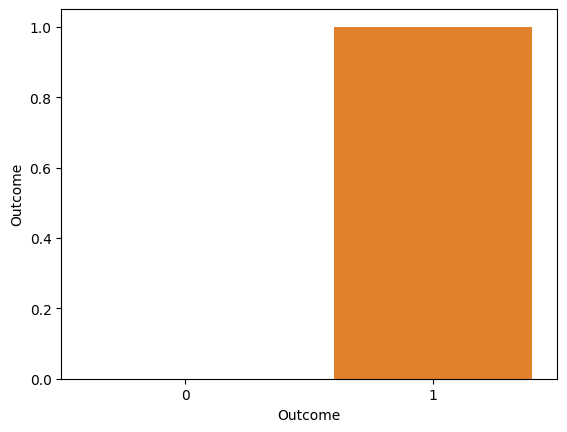

In [16]:
for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col, plot=True)

## Analysis of Numeric Variables by Target

In [17]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(pd.DataFrame({numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)

         Pregnancies_mean
Outcome                  
0                   3.298
1                   4.866




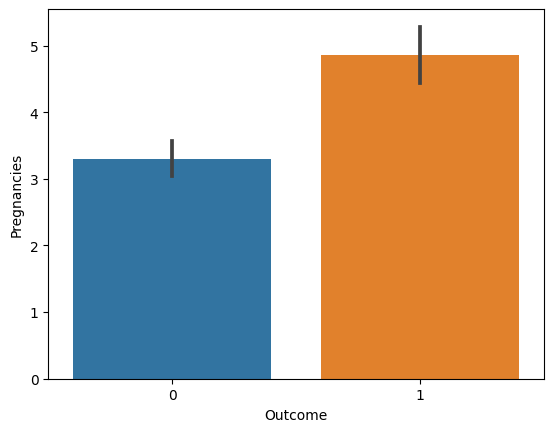

         Glucose_mean
Outcome              
0             109.980
1             141.257




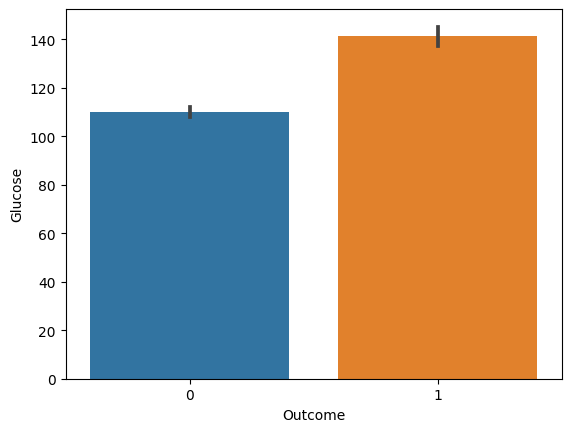

         BloodPressure_mean
Outcome                    
0                    68.184
1                    70.825




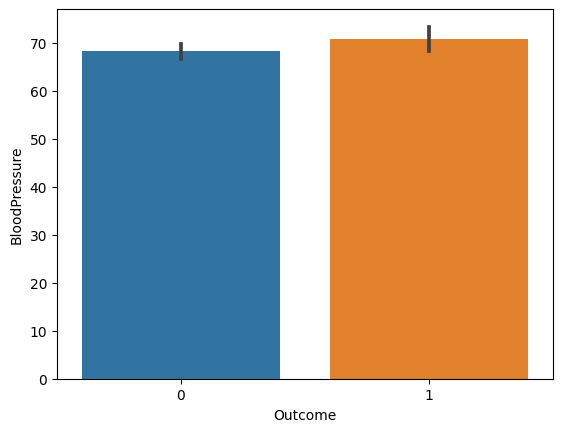

         SkinThickness_mean
Outcome                    
0                    19.664
1                    22.164




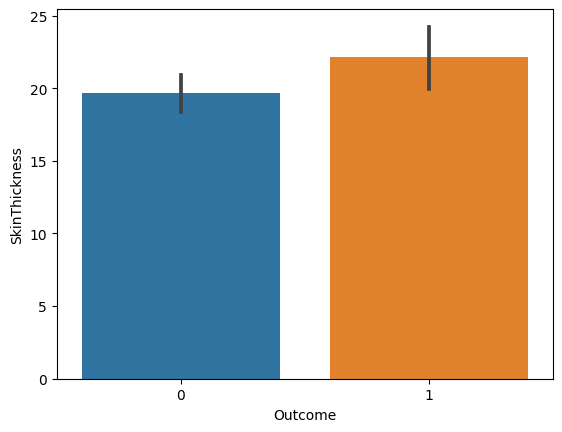

         Insulin_mean
Outcome              
0              68.792
1             100.336




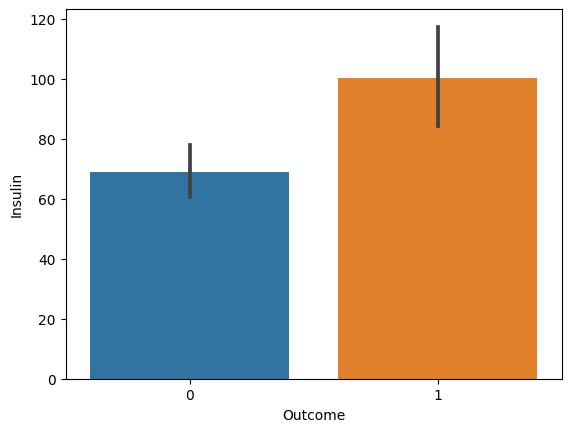

         BMI_mean
Outcome          
0          30.304
1          35.143




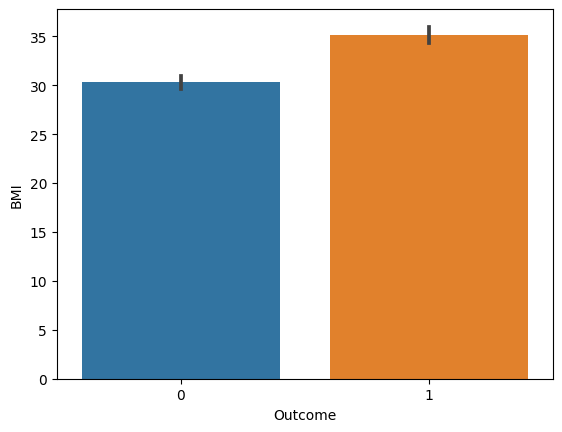

         DiabetesPedigreeFunction_mean
Outcome                               
0                                0.430
1                                0.550




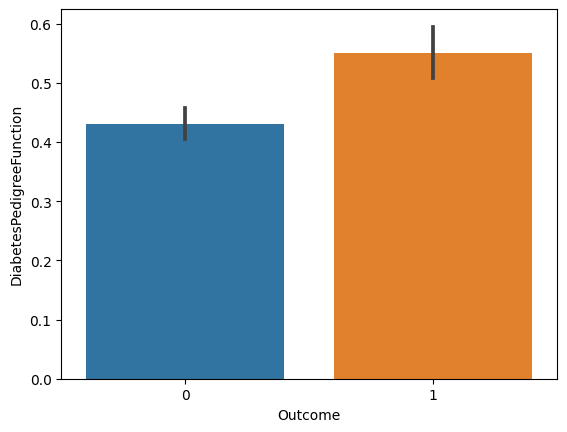

         Age_mean
Outcome          
0          31.190
1          37.067




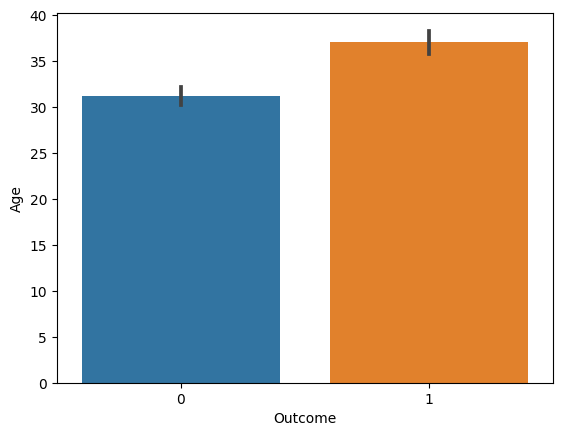

In [18]:
for col in num_cols:
    target_summary_with_num(df, "Outcome", col, plot=True)

# 4-Correlation Analysis

<div style="border-radius: 10px; border: solid #484366;padding: 15px; background-color: #FCF5FB; font-size:100%; text-align:left">

Correlation analysis is a statistical method used to evaluate the strength and direction of the linear relationship between two quantitative variables. It quantifies the degree to which the variables change together. The result of the analysis is expressed as a correlation coefficient, which ranges from -1 to 1. 

- A coefficient close to 1 indicates a strong positive correlation, meaning that as one variable increases, the other tends to increase as well.
- A coefficient close to -1 signifies a strong negative correlation, implying that as one variable increases, the other tends to decrease.
- A coefficient near 0 suggests little to no linear relationship between the variables.

Correlation analysis is crucial for data exploration, feature selection, and identifying variables that might influence each other for further analysis or predictive modeling. However, it's important to remember that correlation does not imply causation; two variables may be correlated without one directly causing the changes in the other.

In [19]:
corr = df[num_cols].corr()
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000


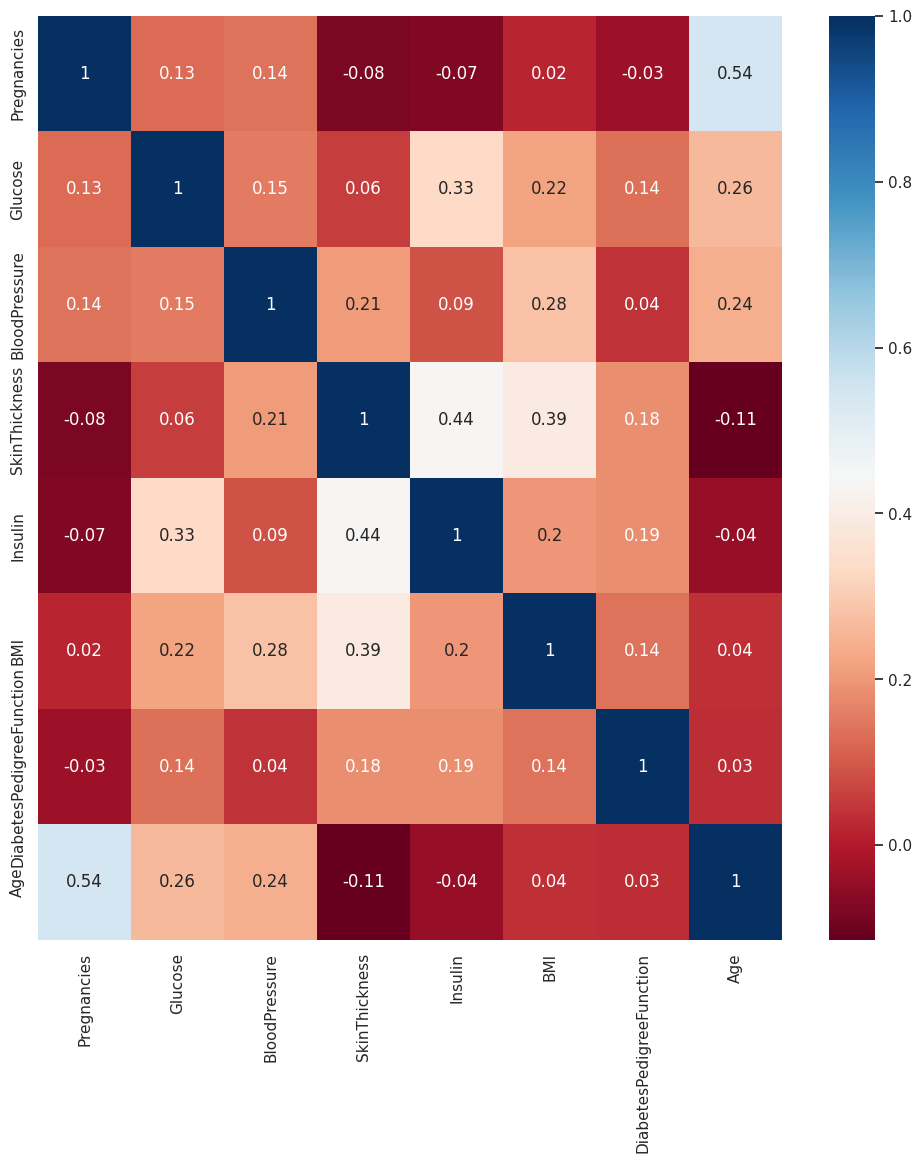

In [20]:
# Correlation heatmap without using functions

sns.set(rc={"figure.figsize": (12, 12)})
corr_values = corr.round(2)
sns.heatmap(corr, cmap="RdBu", annot=corr_values)
plt.show(block=True)

In [21]:
# Creation of correlation heat map using the function

def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={"figure.figsize": (12, 12)})
        corr_values = corr.round(2)
        sns.heatmap(corr, cmap="RdBu", annot=corr_values)
        plt.show(block=True)
    return drop_list

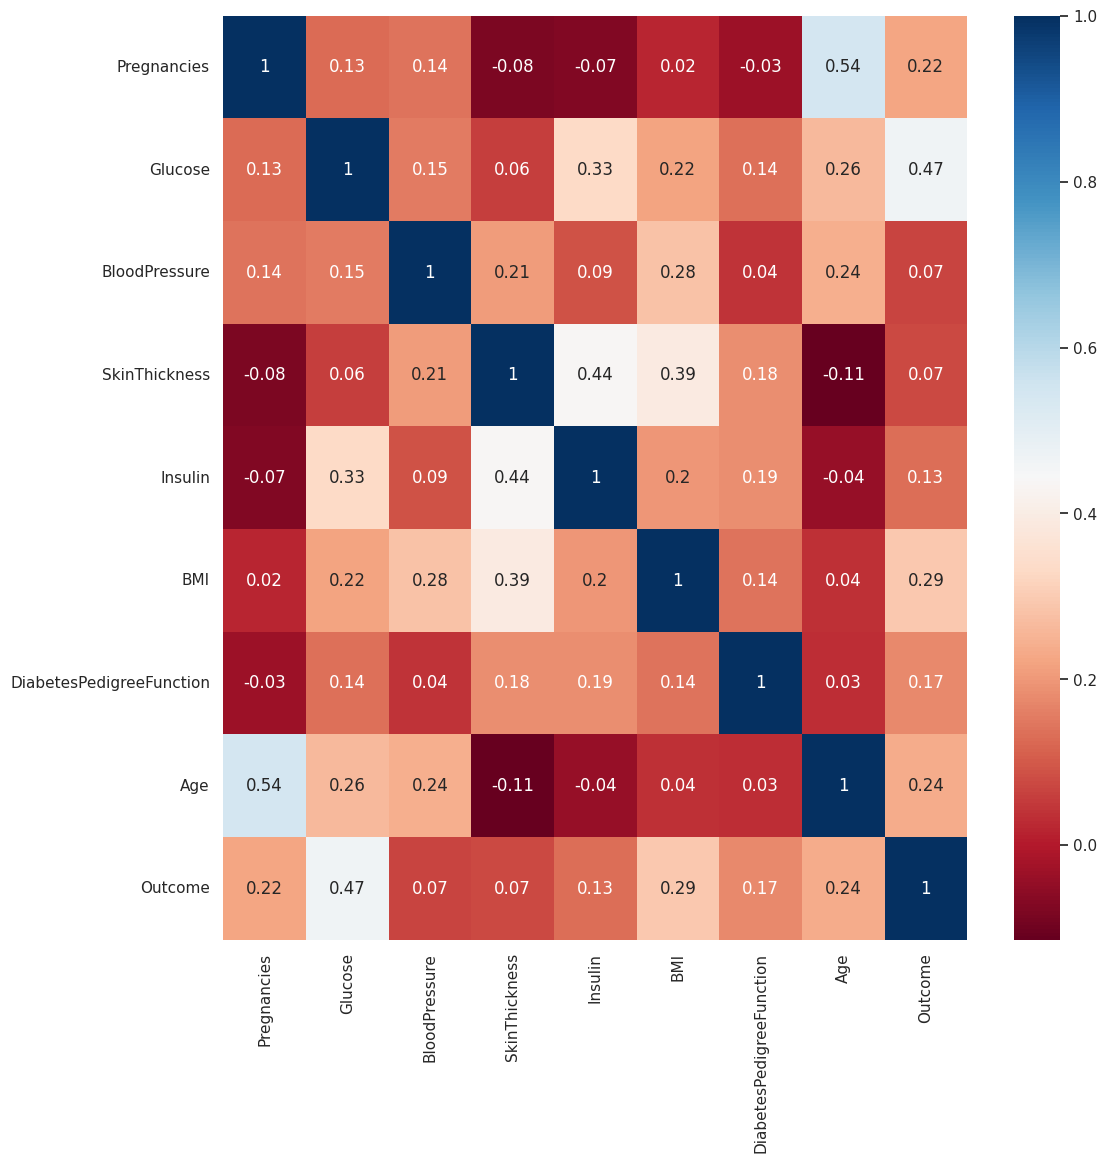

[]

In [22]:
high_correlated_cols(df, plot=True)

**Target Variable Analysis**

In [23]:
df.groupby(grab_col_names(df)[1]).agg({"Outcome": "mean"})

df.groupby("Outcome")[grab_col_names(df)[0]].mean()

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


,Outcome
Outcome,
0,0.000
1,1.000


# 5-Outliers

<div style="border-radius: 10px; border: solid #484366;padding: 15px; background-color: #FCF5FB; font-size:100%; text-align:left">

**Outliers** are data points that differ significantly from other observations in a dataset. They can occur due to variability in the measurement or may indicate experimental errors; sometimes, outliers are simply unusual observations not explained by the majority of the data. Identifying and understanding outliers is crucial in data analysis for several reasons:

**Impact on Statistical Analysis:** Outliers can significantly affect the results of statistical analyses. For example, they can skew the mean of the data and inflate the standard deviation, leading to misleading interpretations.

**Data Integrity:** Outliers may indicate a mistake in data collection (e.g., errors in measurement, data entry errors) or genuine but rare events. Determining the cause of outliers is important for assessing data quality.

**Model Performance:** In machine learning, outliers can affect the performance of models. Some models are sensitive to outliers, which can lead to poor predictions for new data. Identifying and properly handling outliers is essential for building robust models.

**Discovery of Unexpected Insights:** In some cases, outliers represent valuable information about the data set or the phenomenon being studied. Investigating outliers can lead to new insights or discoveries.

There are various methods to detect outliers, including statistical tests, visualization techniques, and machine learning algorithms. How to handle outliers depends on their cause and the context of the study—options include ignoring, transforming, or removing them, or treating them as a separate group.

In [24]:
q1 = df["Age"].quantile(0.25)
print("q1=" + str(q1))

q3 = df["Age"].quantile(0.75)
print("q3=" + str(q3))

iqr = q3 - q1
print("iqr=" + str(iqr))

up = q3 + 1.5*iqr
print("up=" + str(up))

low = q1 - 1.5*iqr
print("low=" + str(low))

q1=24.0
q3=41.0
iqr=17.0
up=66.5
low=-1.5


In [25]:
df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None) 

True

In [26]:
df[(df["Age"] < low) | (df["Age"] > up)] 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
123,5,132,80,0,0,26.800,0.186,69,0
363,4,146,78,0,0,38.500,0.520,67,1
453,2,119,0,0,0,19.600,0.832,72,0
459,9,134,74,33,60,25.900,0.460,81,0
489,8,194,80,0,0,26.100,0.551,67,0
537,0,57,60,0,0,21.700,0.735,67,0
666,4,145,82,18,0,32.500,0.235,70,1
674,8,91,82,0,0,35.600,0.587,68,0
684,5,136,82,0,0,0.000,0.640,69,0


In [27]:
df[(df["Age"] < low) | (df["Age"] > up)].index 

Index([123, 363, 453, 459, 489, 537, 666, 674, 684], dtype='int64')

In [28]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + (interquantile_range * 1.5)
    low_limit = quartile1 - (interquantile_range * 1.5)
    return low_limit, up_limit
    

In [29]:
outlier_thresholds(df, "Age")

(-1.5, 66.5)

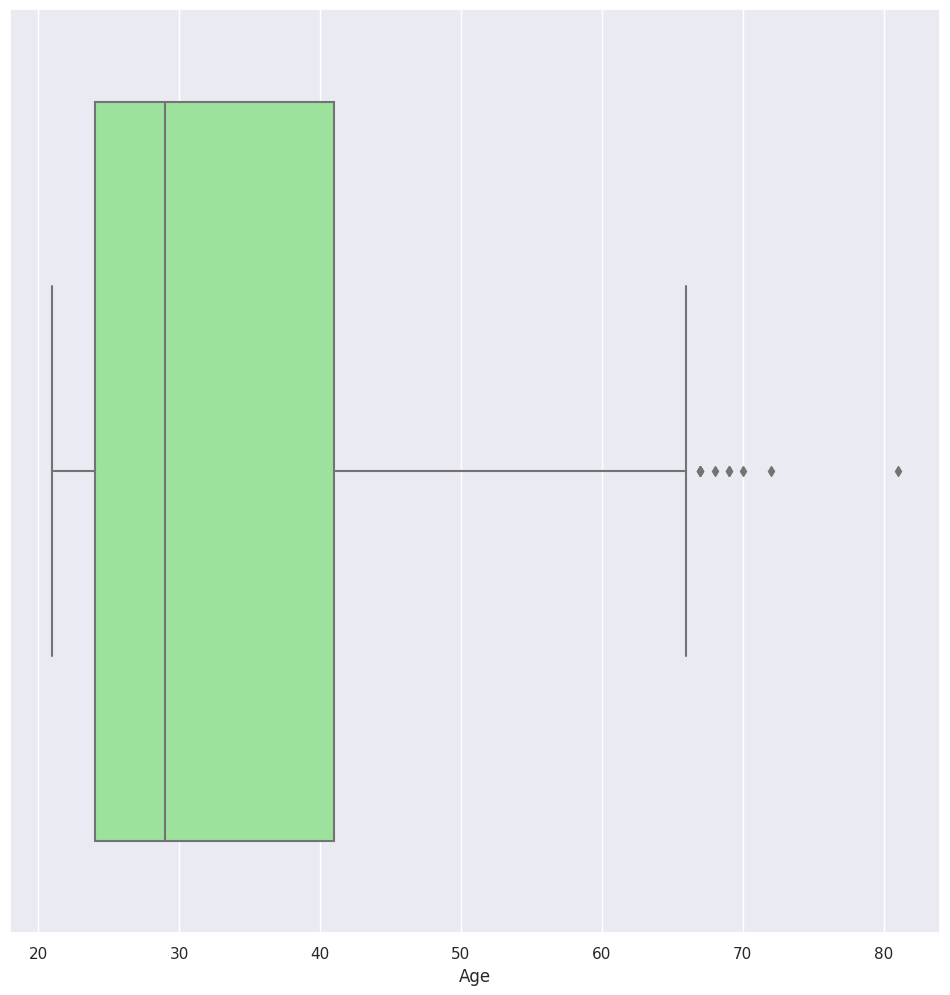

In [30]:
sns.boxplot(x=df["Age"], color='lightgreen')
plt.show()

In [31]:
outlier_thresholds(df, "BloodPressure")

(35.0, 107.0)

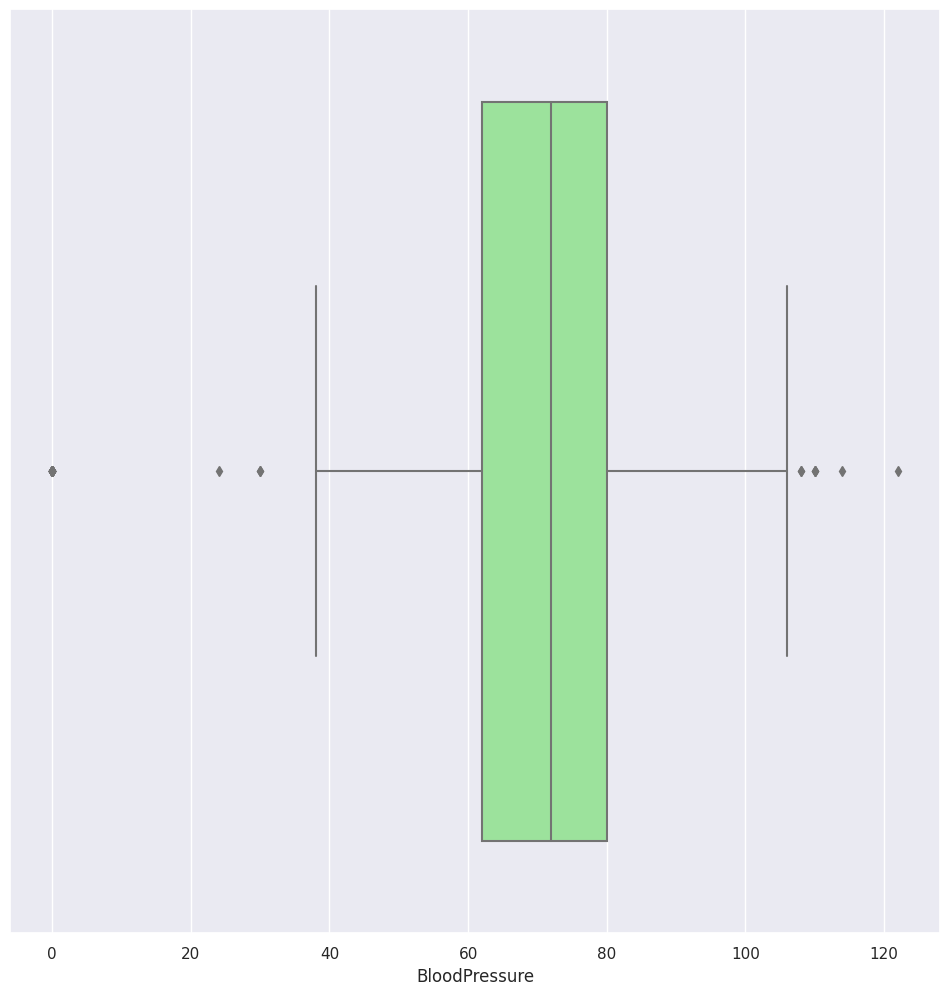

In [32]:
sns.boxplot(x=df["BloodPressure"], color='lightgreen')
plt.show()

In [33]:
low, up = outlier_thresholds(df, "BloodPressure")
low, up

(35.0, 107.0)

In [34]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [35]:
check_outlier(df, "Age")

True

In [36]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True


### Catching Outlier Values

In [37]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
         print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])
            
    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [38]:
grab_outliers(df, "Age")

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
123            5      132             80              0        0 26.800   
363            4      146             78              0        0 38.500   
453            2      119              0              0        0 19.600   
459            9      134             74             33       60 25.900   
489            8      194             80              0        0 26.100   
537            0       57             60              0        0 21.700   
666            4      145             82             18        0 32.500   
674            8       91             82              0        0 35.600   
684            5      136             82              0        0  0.000   

     DiabetesPedigreeFunction  Age  Outcome  
123                     0.186   69        0  
363                     0.520   67        1  
453                     0.832   72        0  
459                     0.460   81        0  
489                

In [39]:
age_index = grab_outliers(df, "Age", True)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
123            5      132             80              0        0 26.800   
363            4      146             78              0        0 38.500   
453            2      119              0              0        0 19.600   
459            9      134             74             33       60 25.900   
489            8      194             80              0        0 26.100   
537            0       57             60              0        0 21.700   
666            4      145             82             18        0 32.500   
674            8       91             82              0        0 35.600   
684            5      136             82              0        0  0.000   

     DiabetesPedigreeFunction  Age  Outcome  
123                     0.186   69        0  
363                     0.520   67        1  
453                     0.832   72        0  
459                     0.460   81        0  
489                

In [40]:
age_index

Index([123, 363, 453, 459, 489, 537, 666, 674, 684], dtype='int64')

In [41]:
#outlier_thresholds(df, "Age")
#check_outlier(df, "Age")
#grab_outliers(df, "Age")

## Solving the Outlier Problem

### 1-Delete

In [42]:
low, up = outlier_thresholds(df, "Age")
df.shape

(768, 9)

In [43]:
df[~((df["Age"] < low) | (df["Age"] > up))].shape 

(759, 9)

In [44]:
# Let's write a function to be able to delete outliers in other columns as well:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

In [45]:
df.shape

(768, 9)

In [46]:
for col in num_cols:
    new_df = remove_outlier(df, col)

In [47]:
new_df.shape

(759, 9)

**Because of an outlier in one column, we lose other values as well. Therefore, deletion is not always used. Let's examine another method called SUPPRESSION:**

## 2-Re-assignment with threshold

In [48]:
low, up = outlier_thresholds(df, "Age")

In [49]:
df[((df["Age"] < low) | (df["Age"] > up))]["Age"]

123    69
363    67
453    72
459    81
489    67
537    67
666    70
674    68
684    69
Name: Age, dtype: int64

In [50]:
df.loc[((df["Age"] < low) | (df["Age"] > up)), "Age"]

123    69
363    67
453    72
459    81
489    67
537    67
666    70
674    68
684    69
Name: Age, dtype: int64

In [51]:
df.loc[(df["Age"] > up), "Age"] = up
df.loc[(df["Age"] < low), "Age"] = low

/tmp/ipykernel_18/1305316962.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '66.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df["Age"] > up), "Age"] = up


In [52]:
df.loc[((df["Age"] < low) | (df["Age"] > up)), "Age"]

Series([], Name: Age, dtype: float64)

In [53]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[((dataframe[variable]) < low_limit), variable] = low_limit
    dataframe.loc[((dataframe[variable]) > up_limit), variable] = up_limit

In [54]:
df = pd.read_csv("/kaggle/input/diabetes-dataset/diabetes.csv")
# We reloaded the data from the beginning, to avoid confusion
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [55]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "Age"]

df.shape

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


(768, 9)

In [56]:
#Let's suppress the outliers
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True


In [57]:
for col in num_cols:
    replace_with_thresholds(df, col)

/tmp/ipykernel_18/2102070206.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[((dataframe[variable]) < low_limit), variable] = low_limit
/tmp/ipykernel_18/2102070206.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '37.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[((dataframe[variable]) < low_limit), variable] = low_limit
/tmp/ipykernel_18/2102070206.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-190.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[((dataframe[variable]) < low_limit), variable] = low_limi

In [58]:
# We solved the problem by suppressing the outliers:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False


## Multivariate Outlier Analysis

In [59]:
df = pd.read_csv("/kaggle/input/diabetes-dataset/diabetes.csv")

In [60]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies True
Glucose True
BloodPressure True
SkinThickness True
Insulin True
BMI True
DiabetesPedigreeFunction True
Age True
Outcome False


In [61]:
low, up = outlier_thresholds(df, "Age")
low, up

(-1.5, 66.5)

In [62]:
df[((df["Age"] < low) | (df["Age"] > up))].shape

(9, 9)

In [63]:
low, up = outlier_thresholds(df, "BloodPressure")
low, up

(35.0, 107.0)

In [64]:
df[((df["BloodPressure"] < low) | (df["BloodPressure"] > up))].shape

(45, 9)

In [65]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [66]:
df_scores = clf.negative_outlier_factor_
df_scores[0:5]

array([-1.06670781, -1.00444029, -1.07964805, -0.9796959 , -1.16949099])

In [67]:
np.sort(df_scores)[0:5] #en uzak olanlardan 5i

array([-2.59693313, -2.48872536, -2.44091629, -2.42704822, -2.40372289])

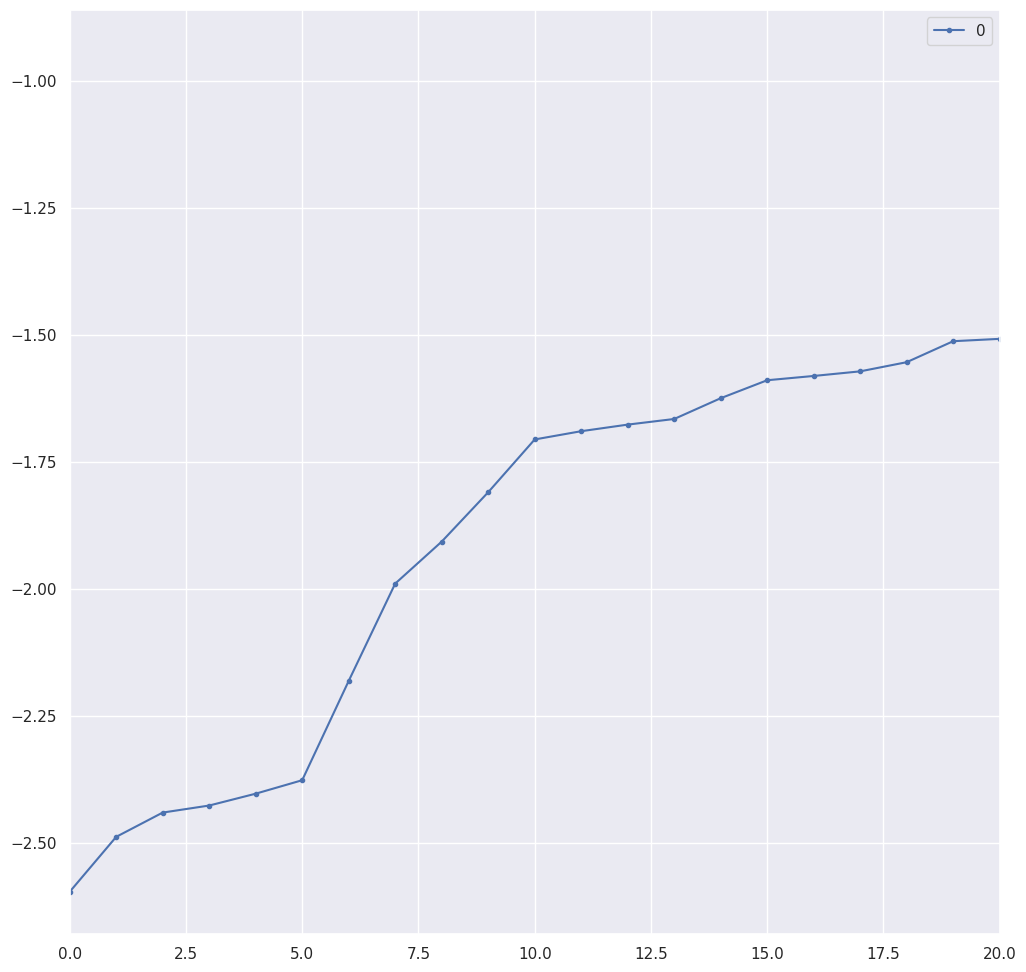

In [68]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()

According to this graph, we can set the threshold value to 5.0, after which it progresses with a steeper ascent.

In [69]:
th = np.sort(df_scores)[5]

In [70]:
df[df_scores < th]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
13,1,189,60,23,846,30.100,0.398,59,1
75,1,0,48,20,0,24.700,0.140,22,0
342,1,0,68,35,0,32.000,0.389,22,0
349,5,0,80,32,0,41.000,0.346,37,1
502,6,0,68,41,0,39.000,0.727,41,1


In [71]:
df[df_scores < th].shape

(5, 9)

In [72]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
Pregnancies,768.000,3.845,3.370,0.000,0.000,0.000,3.000,6.000,9.000,13.000,17.000
Glucose,768.000,120.895,31.973,0.000,57.000,79.000,117.000,140.250,167.000,196.000,199.000
BloodPressure,768.000,69.105,19.356,0.000,0.000,38.700,72.000,80.000,88.000,106.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,0.000,23.000,32.000,40.000,51.330,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,0.000,30.500,127.250,210.000,519.900,846.000
BMI,768.000,31.993,7.884,0.000,0.000,21.800,32.000,36.600,41.500,50.759,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.095,0.140,0.372,0.626,0.879,1.698,2.420
Age,768.000,33.241,11.760,21.000,21.000,21.000,29.000,41.000,51.000,67.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000


In [73]:
df[df_scores < th].index

Index([13, 75, 342, 349, 502], dtype='int64')

In [74]:
df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


# 6-Missing Values

<div style="border-radius: 10px; border: solid #484366;padding: 15px; background-color: #FCF5FB; font-size:100%; text-align:left">

**What is missing value?**
In feature engineering, a missing value refers to a data point that is absent for a variable in an observation. Missing values can arise for various reasons, such as errors during data collection, entry, or processing; refusal of respondents to answer certain questions in a survey; or instances where the information is not applicable. The presence of missing values in a dataset can significantly impact the performance of predictive models and statistical analyses, making it a critical issue to address during the data preprocessing and feature engineering phases of a machine learning project or data analysis task.

**Handling missing values is essential for several reasons:**

**Data Quality:** Ensuring the dataset is complete or handling missing values appropriately improves the quality of the data, leading to more accurate analyses or predictions.

**Model Compatibility:** Most machine learning algorithms require complete datasets to function correctly. Algorithms cannot process missing values directly, so addressing them before model training is crucial.

**Bias Reduction:** Properly dealing with missing values can reduce bias in the data, leading to fairer and more accurate models.

**Improving Model Performance:** Effectively handling missing values can improve the performance of a model by making better use of the available data.

**There are several strategies for handling missing values in feature engineering, including:**

**Deleting Records:** Removing rows with missing values. This method is straightforward but can lead to significant data loss, especially if many observations have missing data.

**Imputation:** Filling in missing values with substitutes, such as the mean, median, or mode of the column for numerical data, or the most frequent category for categorical data. More sophisticated imputation techniques involve using models to predict the missing values based on other available data.

**Using Indicator Variables:** Creating binary variables to indicate the presence of missing values in addition to imputation. This approach can help models use the fact that data was missing as a predictive signal.

**Ignoring:** In some cases, especially with certain types of algorithms, missing values can be ignored, and the model can still be trained with the available complete cases.

The choice of method depends on the nature of the data, the extent and pattern of missingness, and the specific goals of the analysis or predictive modeling task.

In [75]:
df = pd.read_csv("/kaggle/input/diabetes-dataset/diabetes.csv")

In [76]:
# Checking for missing data:
df.isnull().values.any()

False

In [77]:
zero_rows = df[df.isin([0]).any(axis=1)]

print(zero_rows)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0              6      148             72             35        0 33.600   
1              1       85             66             29        0 26.600   
2              8      183             64              0        0 23.300   
3              1       89             66             23       94 28.100   
4              0      137             40             35      168 43.100   
..           ...      ...            ...            ...      ...    ...   
763           10      101             76             48      180 32.900   
764            2      122             70             27        0 36.800   
765            5      121             72             23      112 26.200   
766            1      126             60              0        0 30.100   
767            1       93             70             31        0 30.400   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1      

In [78]:
#We observed that in 657 rows of our data, there are records with at least one column being 0. Now let's assign NaN values to these:
columns_except_outcome = df.columns.difference(['Outcome'])
df[columns_except_outcome] = df[columns_except_outcome].replace(0, np.nan)
print(df)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0          6.000  148.000         72.000         35.000      NaN 33.600   
1          1.000   85.000         66.000         29.000      NaN 26.600   
2          8.000  183.000         64.000            NaN      NaN 23.300   
3          1.000   89.000         66.000         23.000   94.000 28.100   
4            NaN  137.000         40.000         35.000  168.000 43.100   
..           ...      ...            ...            ...      ...    ...   
763       10.000  101.000         76.000         48.000  180.000 32.900   
764        2.000  122.000         70.000         27.000      NaN 36.800   
765        5.000  121.000         72.000         23.000  112.000 26.200   
766        1.000  126.000         60.000            NaN      NaN 30.100   
767        1.000   93.000         70.000         31.000      NaN 30.400   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1      

In [79]:
# Rechecking for missing data:
df.isnull().values.any()

True

In [80]:
df.isnull()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,False,False,False,False,True,False,False,False,False
1,False,False,False,False,True,False,False,False,False
2,False,False,False,True,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
763,False,False,False,False,False,False,False,False,False
764,False,False,False,False,True,False,False,False,False
765,False,False,False,False,False,False,False,False,False
766,False,False,False,True,True,False,False,False,False


In [81]:
df.isnull().sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [82]:
df.isnull().sum().sum() #number of rows with at least one missing field

763

In [83]:
# Solution 1: Deleting
df.dropna().shape
# Solution 2: Filling with Simple Assignment
df["Age"].fillna(df["Age"].mean()).isnull().sum()
df["Age"].fillna(df["Age"].median()).isnull().sum()
df["Age"].fillna(0).isnull().sum()

0

In [84]:
df.apply(lambda x: x.fillna(x.mean()),axis=0)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000,148.000,72.000,35.000,155.548,33.600,0.627,50,1
1,1.000,85.000,66.000,29.000,155.548,26.600,0.351,31,0
2,8.000,183.000,64.000,29.153,155.548,23.300,0.672,32,1
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,4.495,137.000,40.000,35.000,168.000,43.100,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10.000,101.000,76.000,48.000,180.000,32.900,0.171,63,0
764,2.000,122.000,70.000,27.000,155.548,36.800,0.340,27,0
765,5.000,121.000,72.000,23.000,112.000,26.200,0.245,30,0
766,1.000,126.000,60.000,29.153,155.548,30.100,0.349,47,1


<div style="text-align: center; border-radius: 10px; border: solid #484366; padding: 15px; background-color: #FFECC3; font-size: 140%;">
    Thank you for taking the time to review my work 📝<br><br> 🌟 Your feedback, comments, and likes are invaluable to me as they help improve and refine this project further<br><br>Please feel free to share your thoughts and suggestions 💭💬
</div>
